### MicroGrad

-> a tiny autograd engine (autograd -> Automatic gradient (which implements backpropagation))

* Neural networks are just mathematical operations. They take the input data as input and they take the weights of the input data as input and perform some mathematical operations and the outputs are our predictions. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from graphviz import Digraph

#### derivative of a simple function with a single input

In [64]:
def f(x): # parabolic equation (quadratic)  

    return 3*x**2 - 4*x + 5

In [65]:
f(3.0)

20.0

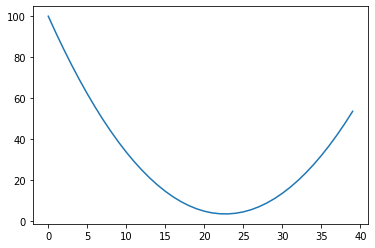

In [66]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(ys)
plt.show()

Q. what is the derivative of this input at any single input x? What is the derivative at different points x?

so basically derivative is how a function would respond at different values of x? so in the below example we changed the value of x by adding h in the function. since we added a positive value to the value of x our function nudged towards a positive direction.

lim h->0 ((f(x+h)-f(x))/h)

In [67]:
h = 0.00000001
x = 3.0
(f(x+h)-f(x))/h

14.00000009255109

In [68]:
h = 0.00000001
x = -3.0
(f(x+h)-f(x))/h

-22.00000039920269

In [69]:
h = 0.00000001
x = 2/3
(f(x+h)-f(x))/h

0.0

#### derivative of a single function with multiple inputs

In [70]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [71]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

a = 2.0
b += h
d3 = a*b + c

b = -3.0
c += h
d4 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope of dx/da", (d2-d1)/h)
print("d3", d3)
print("slope of dx/db", (d3-d1)/h)
print("d4", d4)
print("slope of dx/dc", (d4-d1)/h)

d1 4.0
d2 3.9999699999999994
slope of dx/da -3.000000000064062
d3 4.00002
slope of dx/db 2.0000000000131024
d4 4.00001
slope of dx/dc 0.9999999999621422


#### building micrograd 

In [2]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):

        self.data = data
        self.grad = 0.0  # 0 means no effect meaning we assume that at init it doesnt affect the output
        self._prev = set(_children)
        self._backward = lambda: None # does not do anything, empty function
        self._op = _op
        self.label = label

    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other) # to do operations like Value(a) + 1
        output = Value(self.data + other.data, (self, other), "+")

        def _backward():  
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad

        output._backward = _backward

        return output

    def __radd__(self, other): # other + self

        return self + other

    def __mul__(self, other):

        other = other if isinstance(other, Value) else Value(other) # to do operations like Value(a) * 3
        output = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad

        output._backward = _backward

        return output

    def __pow__(self, other):

        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self

        return self * other

    def __truediv__(self, other): 

        return self * other**-1

    def __neg__(self): # -self

        return self * -1

    def __sub__(self, other): # self - other

        return self + (-other)

    def exp(self):

        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, _children=(self, ), _op="tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
            
                for child in v._prev:
                    build_topo(child)

                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [73]:
a = Value(4.0)
b = Value(2.0)
a/b

Value(data=2.0)

In [74]:
a - b

Value(data=2.0)

In [75]:
a**10

Value(data=1048576.0)

In [3]:
def trace(root):
    
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)

    return nodes, edges

def draw_dot(root):

    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ("record") node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # and connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

In [54]:
Value(10) + 1

Value(data=11)

##### Manual backpropagation

In [4]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d*f
L.label = "L"

print("d", d)
print("children of d", d._prev)
print("operation used for creating d", d._op)

d Value(data=4.0)
children of d {Value(data=10.0), Value(data=-6.0)}
operation used for creating d +


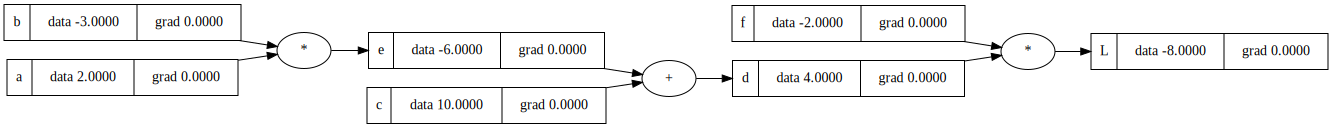

In [5]:
draw_dot(L)

Calculating the loss function wrt the weights of the NN so we need to know how the weights are impacting the loss function so basically we are interested in the derivative of the output wrt to the sum of its leaf nodes and those leaf nodes would be the weights of the neural network.

In [6]:
L.grad = 1.0

In [7]:
f.grad = 4.0
d.grad = -2.0

In [8]:
# dd/dc = 1.0
# dd/de = 1.0

# d = c+e
# dd/dc = d(c+e)
# dd/dc = dc/dc + de/dc
# dd/dc = 1 + 0 
# dd/dc = 1

# WANT:
# dL/dc

# KNOW:
# dL/dd
# dd/dc

# dL/dc = dL/dd * dd/dc
# dL/dc = -2.0 * 1
# dL/dc = -2.0

In [9]:
c.grad = -2.0
e.grad = -2.0

In [10]:
# dl/da = ?

# dl/da = de/da * dL/de

# e = a*b
# de/da = d(a*b)
# de/da = b
# de/db = a

# dl/da = b * (-2.0)
# dl/da = 6.0
# dl/db = -4.0

In [11]:
a.grad = 6.0
b.grad = -4.0

One step of optimization loop

In [12]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a+b
d = e+c
L = d+f

print(L)

Value(data=7.04)


Visualizing a tanh activation function using matplotlib and numpy

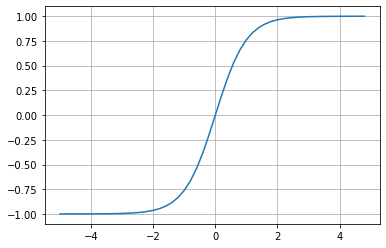

In [13]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()
plt.show()

Using what we have learnt to understand the working of a neuron

In [4]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()

In [78]:
# o.grad = 1.0

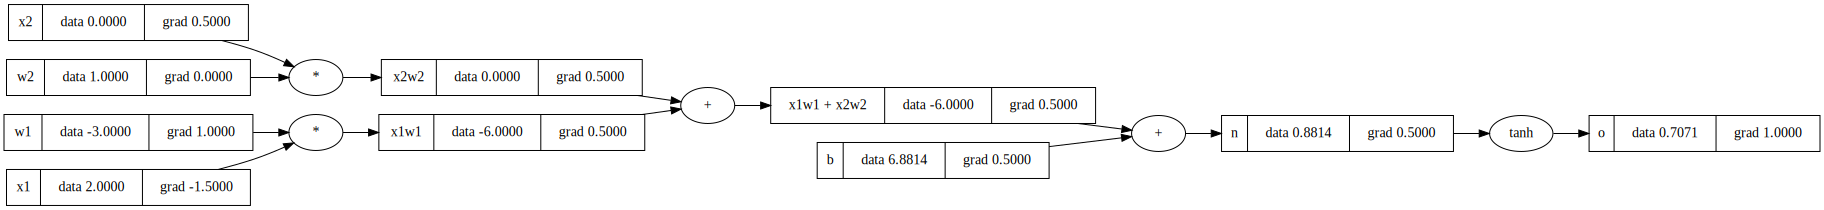

In [5]:
draw_dot(o)

In [17]:
o.backward()

In [18]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2

1 - (o.data**2)

0.4999999999999999

In [19]:
n.grad = 0.5

In [20]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [21]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [22]:
# do/dx2 = do/dx2w2 * dx2w2/dx2
# do/dx2 = 0.5 * w2.data

# do/dw2 = do/dx2w2 * dx2w2/dw2
# do/dw2 = 0.5 * x2.data

In [23]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [24]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

#### automating the backpropagation rather than performing it manually

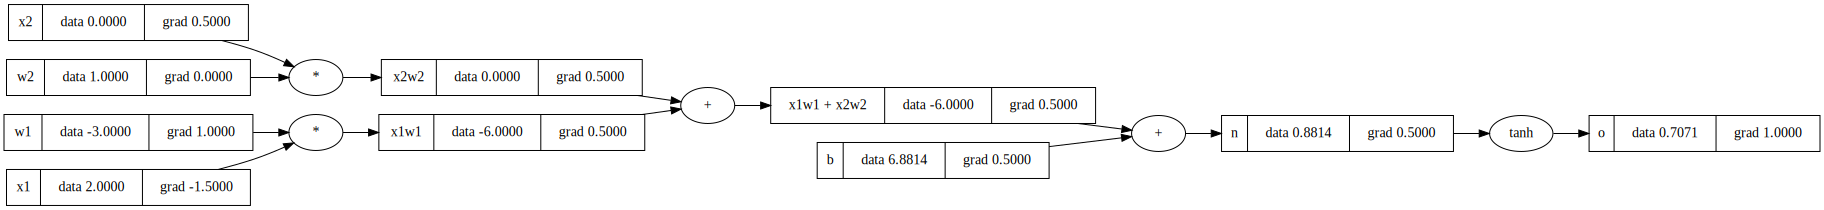

In [6]:
draw_dot(o)

In [28]:
o.grad = 1.0

In [29]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

Topological sort

In [7]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
    
        for child in v._prev:
            build_topo(child)

        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

In [8]:
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

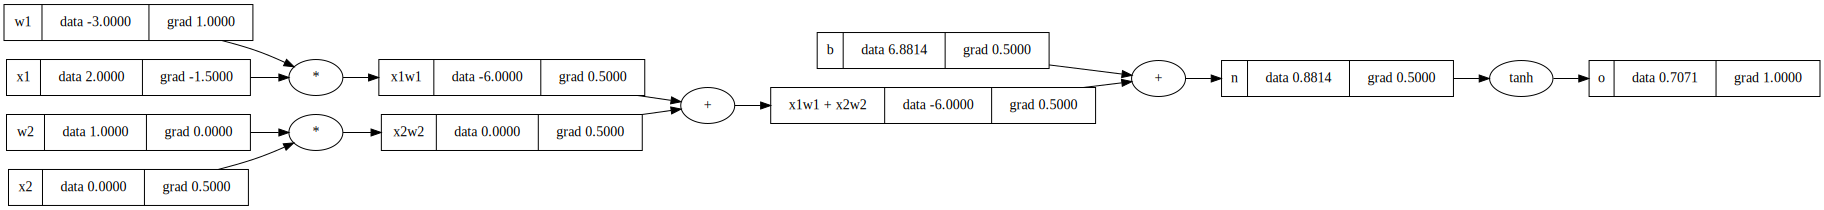

In [32]:
draw_dot(o)

One node is used multiple times bug !

In [47]:
a = Value(3.0, label="a")
b = a+a
b.label = "b"

In [48]:
b.backward()

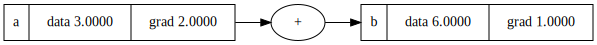

In [49]:
draw_dot(b)

Another example of the bug!

In [50]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a*b
e = a+b
f = d*e

d.label = "d"
e.label = "e"
f.label = "f"

In [51]:
f.backward()

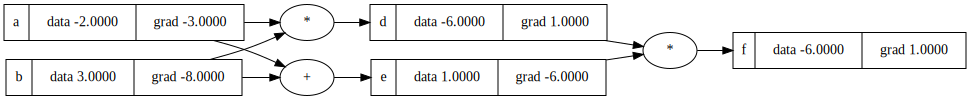

In [52]:
draw_dot(f)

Using exp to derive tanh

In [89]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e-1)/(e+1)
o.label = "o"
e.label = "e"
o.backward()

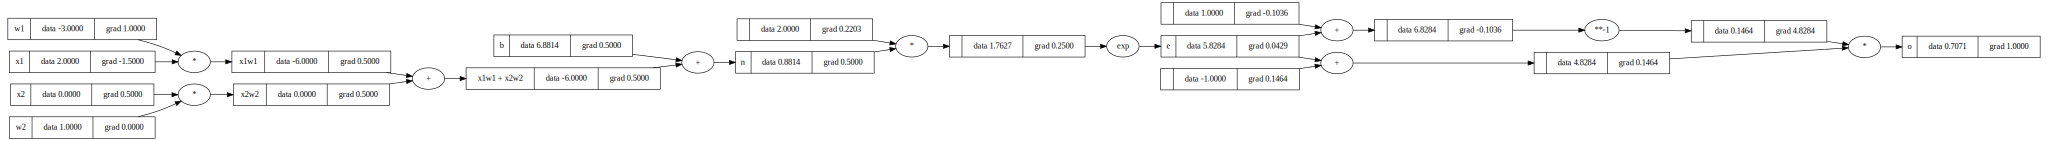

In [90]:
draw_dot(o)

#### Building a Neural network

In [39]:
class Neuron:

    def __init__(self, nin):  # nin -> number of inputs

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):

        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):

        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):

        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:

    def __init__(self, nin, nouts):

        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)

        return x

In [40]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4882901601631213)

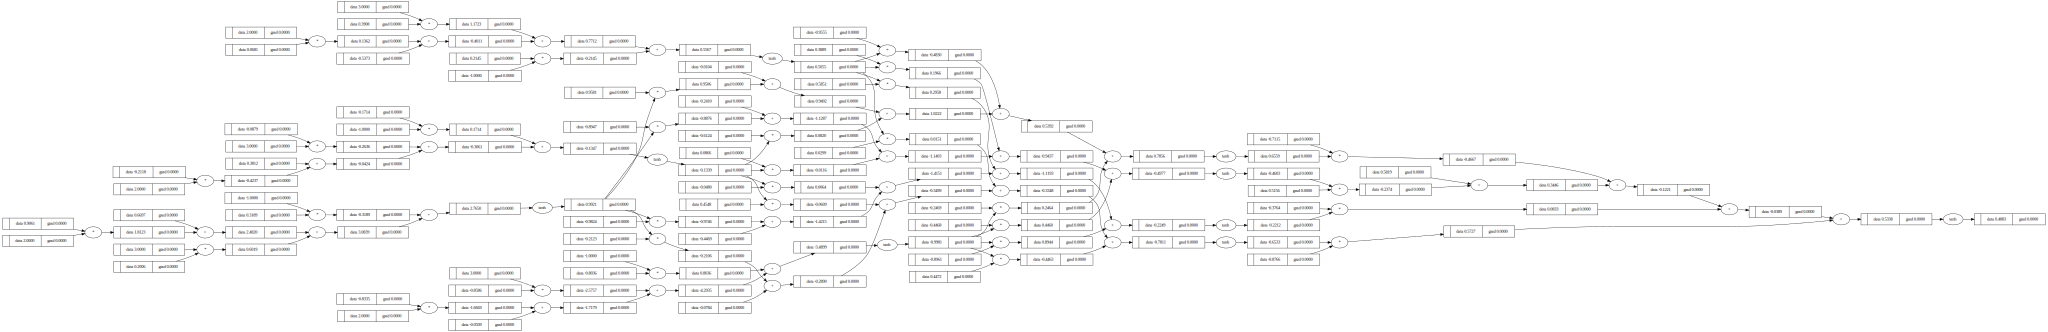

In [41]:
draw_dot(n(x))